In [1]:
!pip3 install torchrl
!pip3 install vmas
!pip3 install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
  Created wheel for vmas: filename=vmas-1.5.2-py3-none-any.whl size=260251 sha256=81471ed65068a49262aacac90cb3a587080557e9ab0b2a428b7a3fe8c119d112
  Stored in directory: /root/.cache/pip/wheels/a7/6f/80/31791456a87da225991ef3a80730ff89d3b96fe30ffba64d3a
Successfully built vmas
  Attempting uninstall: gym-notices
    Found existing installation: gym-notices 0.1.0
    Uninstalling gym-notices-0.1.0:
      Successfully uninstalled gym-notices-0.1.0


In [2]:
# Torch
import torch

# Tensordict modules
from tensordict.nn import set_composite_lp_aggregate, TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

In [49]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 30_000  # Number of team frames collected per training iteration
n_iters = 15  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 15  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

# disable log-prob aggregation
set_composite_lp_aggregate(False).set()

In [50]:
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 3

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    render_mode="rgb_array", # Explicitly set render mode
    headless=False, # Explicitly disable headless mode
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

/usr/local/lib/python3.12/dist-packages/vmas/simulator/utils.py:326: UserWarning: Scenario kwargs: {'render_mode': 'rgb_array', 'headless': False} passed but not used by the scenario. This will turn into an error in future versions.
  warnings.warn(


In [51]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([300, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([300, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([300, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([300, 3]),
        data_cls=None),
    device=cpu,
    shape=torch.Size([300]),
    data_cls=None)
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([300, 3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([300, 3, 1]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([300, 3, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
         

In [52]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [53]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)
check_env_specs(env)

2026-02-06 13:37:19,566 [torchrl][INFO]    check_env_specs succeeded! [END]


In [54]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([300, 5, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([300, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([300, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        final_rew: Tensor(shape=torch.Size([300, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([300, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([300, 5, 3]),
                    device=cpu,
                    is_shared=False),
                observation: Tensor(shape=torch.Size([300, 5, 3, 18]), device=cpu, dty

In [55]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2
        * env.full_action_spec[env.action_key].shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

In [56]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [57]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec_unbatched,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.full_action_spec_unbatched[env.action_key].space.low,
        "high": env.full_action_spec_unbatched[env.action_key].space.high,
    },
    return_log_prob=True,
)

In [58]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

In [59]:
print("Running policy:", policy(env.reset()))
print("Running value:", critic(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([300, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                action_log_prob: Tensor(shape=torch.Size([300, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([300, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([300, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        final_rew: Tensor(shape=torch.Size([300, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([300, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([300, 3]),
                    device=cpu,
                    is_shared=F

In [60]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

/usr/local/lib/python3.12/dist-packages/torchrl/collectors/_base.py:1045: DeprecationWarning: SyncDataCollector has been deprecated and will be removed in v0.13. Please use Collector instead.
  warnings.warn(


In [61]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [62]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coeff=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [63]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()



episode_reward_mean = 2.89418363571167: 100%|██████████| 10/10 [06:57<00:00, 41.74s/it]


2026-02-06 13:37:41,256 [torchrl][INFO]    Initialized LazyTensorStorage with torch.Size([30000]) shape [END]




episode_reward_mean = -0.4085558354854584:   2%|▏         | 1/50 [00:39<31:57, 39.12s/it]

episode_reward_mean = 0.23810502886772156:   4%|▍         | 2/50 [01:22<33:17, 41.61s/it]

episode_reward_mean = 0.9974480271339417:   6%|▌         | 3/50 [02:01<31:32, 40.27s/it] 

episode_reward_mean = 1.5900278091430664:   8%|▊         | 4/50 [02:39<30:25, 39.67s/it]

episode_reward_mean = 2.091705560684204:  10%|█         | 5/50 [03:20<29:58, 39.96s/it] 

episode_reward_mean = 2.4330713748931885:  12%|█▏        | 6/50 [03:59<29:11, 39.81s/it]

episode_reward_mean = 2.7681052684783936:  14%|█▍        | 7/50 [04:39<28:32, 39.81s/it]

episode_reward_mean = 2.8592371940612793:  16%|█▌        | 8/50 [05:18<27:45, 39.64s/it]

episode_reward_mean = 2.8641555309295654:  18%|█▊        | 9/50 [05:58<27:05, 39.65s/it]

episode_reward_mean = 2.8969786167144775:  20%|██        | 10/50 [06:38<26:27, 39.70s/it]

episode_reward_mean = 2.9611921310424805:  22%|██▏       | 11/50 [07:18<25:52, 39.80s/it]

epi

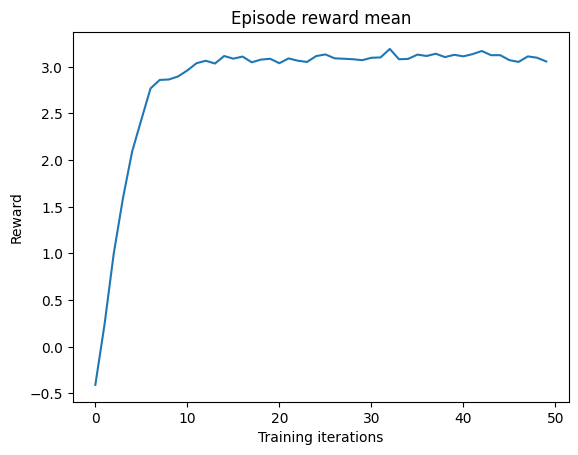

In [64]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

In [26]:
!apt-get update
!apt-get install -y python3-opengl
!apt-get install -y x11-utils
!apt-get install -y xvfb
!pip install pyvirtualdisplay

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libglu1-mesa
Suggested packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


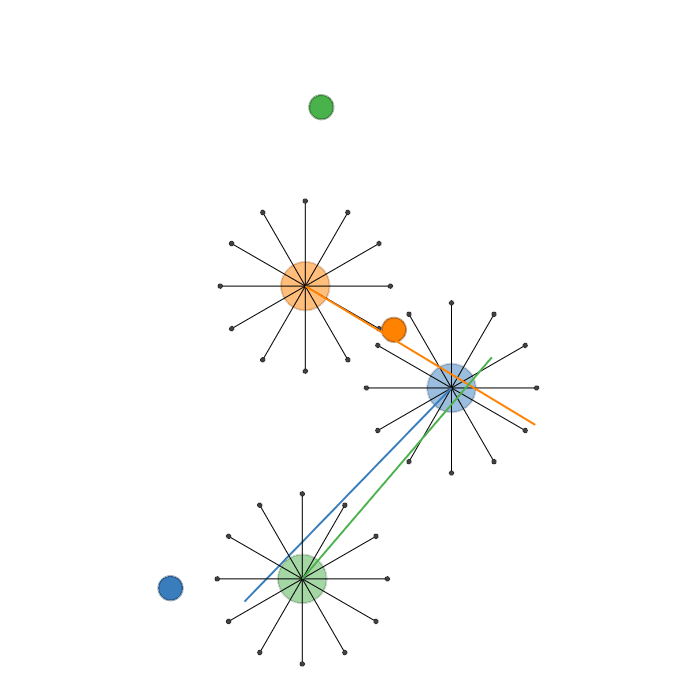

In [66]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()
from PIL import Image

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render(mode="rgb_array")))
env.frames = []
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=policy,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
env.frames[0].save(
    f"{scenario_name}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open(f"{scenario_name}.gif", "rb").read())